<a href="https://colab.research.google.com/github/ashwin-srdy/face-Emotion-recognition/blob/main/face_emotion_detecting_vgg16_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [ ]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
                                  
!cp kaggle.json ~/.kaggle/      #   (!cp [   API token file name   ] ~/.kaggle/)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

 80% 48.0M/60.3M [00:00<00:00, 268MB/s]
100% 60.3M/60.3M [00:00<00:00, 263MB/s]


In [ ]:
from zipfile import ZipFile
zf = ZipFile('fer2013.zip', 'r')
zf.extractall('/content')
zf.close()

# 2. Parameter

### Removing unwanted folders (fear)

In [ ]:
for path in ['/content/train/','/content/test/']:
  for r,d,f in os.walk(path):
    if (len(d)==0) and (str(r).split('/')[3] in 'fear,disgust'):
      for img in f:
        os.unlink(r+'/'+img)
      os.rmdir(r)
      #print(str(r).split('/')[3])
      #for img in os.walk('/content/train/'+i):

In [ ]:
for path in ['/content/train/','/content/test/']:
  for r,d,f in os.walk(path):
    num=435
    print(str(r).split('/')[3],'found',len(f),'images')
    '''for img in f[435:]:
      os.unlink(r+'/'+img)
    num = 110'''
  

 found 0 images
angry found 3995 images
surprise found 3171 images
neutral found 4965 images
sad found 4830 images
happy found 7215 images
 found 0 images
angry found 958 images
surprise found 831 images
neutral found 1233 images
sad found 1247 images
happy found 1774 images


In [ ]:
# declare path
train_dir = '/content/train/'
test_dir = '/content/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Happy','Neutral','Sad','Surprise']

# 3. Prepare data

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 24176 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


# 4. Explore data

In [ ]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

,angry,surprise,neutral,sad,happy
train,3995,3171,4965,4830,7215
test,958,831,1233,1247,1774


In [ ]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}

In [ ]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


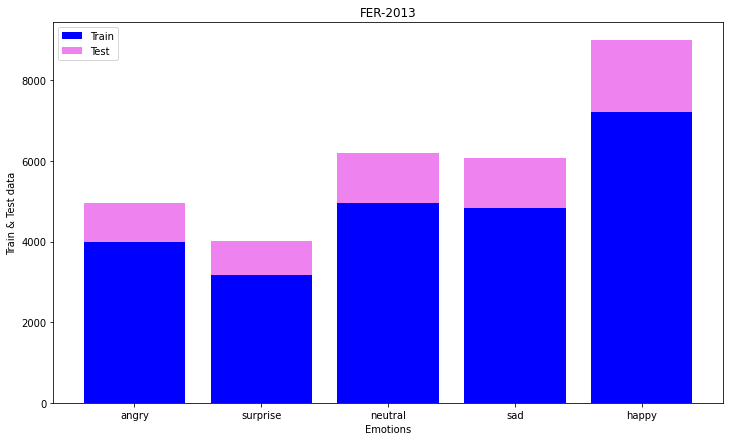

In [ ]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

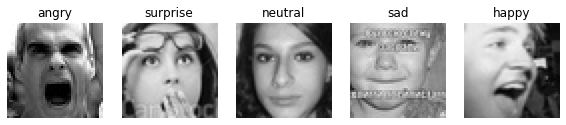

In [ ]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [ ]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False

In [ ]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 gaussian_noise_1 (GaussianN  (None, 1, 1, 512)        0         
 oise)                                                           
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                      

In [ ]:
# Model trainable

print("Model trainable",len(model.trainable_variables))

Model trainable 24


In [ ]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

# Saving Model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/100
378/378 [==============================] - 38s 96ms/step - loss: 3.5478 - accuracy: 0.7625 - precision: 0.3652 - recall: 0.2538 - auc: 0.6450 - f1_score: 0.2989 - val_loss: 9.5891 - val_accuracy: 0.6854 - val_precision: 0.2135 - val_recall: 0.2135 - val_auc: 0.5283 - val_f1_score: 0.2126 - lr: 1.0000e-04
Epoch 2/100
378/378 [==============================] - 34s 89ms/step - loss: 2.9173 - accuracy: 0.7961 - precision: 0.4853 - recall: 0.3246 - auc: 0.7306 - f1_score: 0.3885 - val_loss: 2.2773 - val_accuracy: 0.7725 - val_precision: 0.4260 - val_recall: 0.3953 - val_auc: 0.7295 - val_f1_score: 0.4087 - lr: 1.0000e-04
Epoch 3/100
378/378 [==============================] - 34s 89ms/step - loss: 2.4816 - accuracy: 0.8206 - precision: 0.5790 - recall: 0.3776 - auc: 0.7936 - f1_score: 0.4565 - val_loss: 1.5922 - val_accuracy: 0.8491 - val_precision: 0.7000 - val_recall: 0.4298 - val_auc: 0.8448 - val_f1_score: 0.5313 - lr: 1.0000e-04
Epoch 4/100
378/378 [=========================

# 6. Evaluate Model

## 6.1 Check some Score 

In [ ]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

36/36 [==============================] - 1s 25ms/step - loss: 2.0042 - accuracy: 0.8535 - precision: 0.5713 - recall: 0.4838 - auc: 0.8335 - f1_score: 0.5244


In [ ]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))




Model Scores



,Metric Name,Train,Validate
0,Loss,0.787,2.004
1,Accuracy,0.959,0.853
2,Precision,0.910,0.571
3,Recall,0.839,0.484
4,Auc,0.987,0.833
5,F1_Score,0.873,0.524


## 6.2 Visualize results

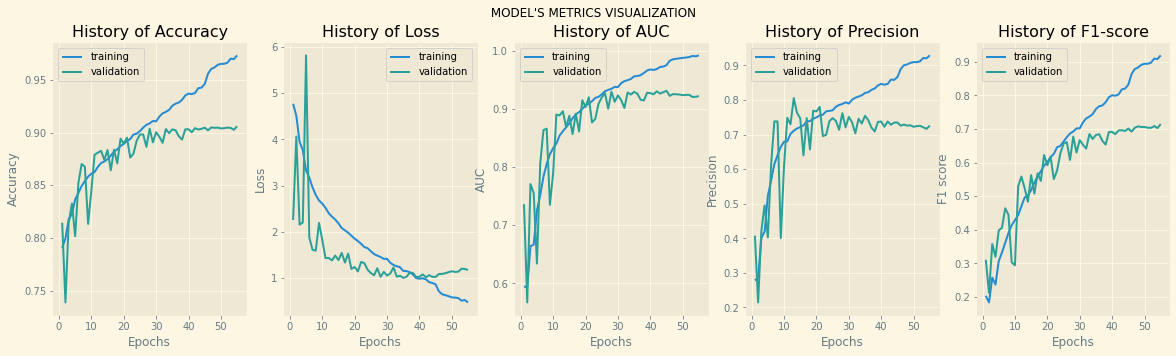

In [ ]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

## 6.3 Confusion Matrix

In [ ]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

Confusion matrix, without normalization

[[131  19 269 225 177 137]
 [ 14   2  27  26  20  22]
 [252  17 527 456 288 234]
 [159  21 383 267 215 188]
 [189  19 348 287 226 178]
 [127  13 230 208 147 106]]





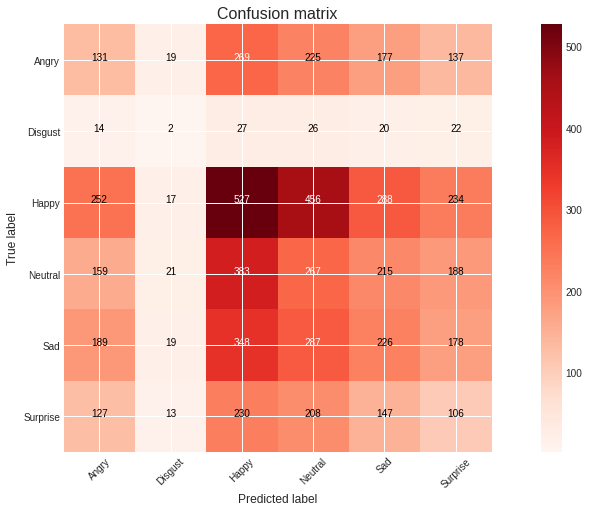

In [ ]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

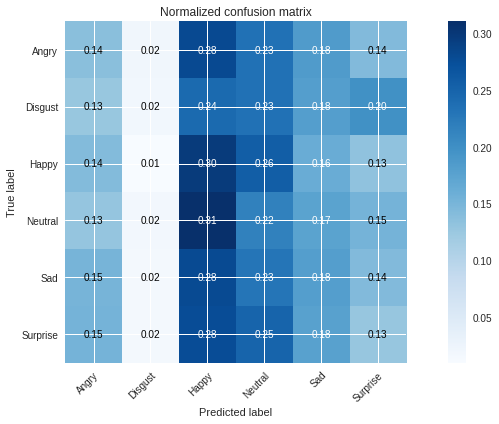

In [ ]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


# 7. Save Model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# 8. Test/Predict

In [ ]:
import keras
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [ ]:
img_path='/content/train/happy/Training_10133389.jpg'
test_image=image.load_img(img_path,target_size= IMAGE_SIZE,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)

(48, 48, 1)


In [ ]:
img=image.load_img(img_path,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [ ]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
new_classes = ['disgust','angry','surprise','neutral','sad','happy']
print('The person facial emotion is:',classes[y_pred])

[1. 0. 0. 0. 0. 0.]
The person facial emotion is: Angry


### How to predict a single image with Keras ImageDataGenerator?
https://stackoverflow.com/questions/63703280/how-to-predict-a-single-image-with-keras-imagedatagenerator

# Best model V23